$\newcommand{\xv}{\mathbf{x}}
 \newcommand{\wv}{\mathbf{w}}
 \newcommand{\bv}{\mathbf{b}}
 \newcommand{\yv}{\mathbf{y}}
 \newcommand{\zv}{\mathbf{z}}
 \newcommand{\Chi}{\mathcal{X}}
 \newcommand{\R}{\rm I\!R}
 \newcommand{\sign}{\text{sign}}
 \newcommand{\Tm}{\mathbf{T}}
 \newcommand{\Xm}{\mathbf{X}}
 \newcommand{\Zm}{\mathbf{Z}}
 \newcommand{\Wm}{\mathbf{W}}
 \newcommand{\Ym}{\mathbf{Y}}
 \newcommand{\I}{\mathbf{I}}
 \newcommand{\muv}{\boldsymbol\mu}
 \newcommand{\Sigmav}{\boldsymbol\Sigma}
$

# Recurrent Neural Networks

With supervised learning, we have learned how we can make an agent develop its model to make an estimate for the given inputs. For this training, we feed relevant outputs for the inputs. For some problems, however, this approach does not work. For instance, prediction of tomorrow's weather or stock prices without knowing the changes over past weeks, months, or years can be naive. Knowing the changes or activities in the past will help tremendously in making a good prediction. 

We categorize this kind of data as time series, and RNN is very useful for predicting them. 
Thus, RNN has been applied to stock market, natural language processing (sentences, documents, or audio), or brain computer interfaces (electroencephalography signals).  

The RNN can be modeled as recursive connection on each neuron or on entire layer in the following figures. 


### Single Recurrent Neuron
$$
\yv_{(t)} = h( \Wm_x^\top \xv_{(t)} + \Wm_y^\top \yv_{(t-1)} + \bv)
$$

![](http://webpages.uncc.edu/mlee173/teach/itcs6156/images/class/RNN.png)

<br/><br/><br/></br>

### Recurrent Layer of Neurons

$$
\yv_{(t)} = h( \Xm_{(t)} \Wm_x  + \Ym_{(t-1)} \Wm_y  + \bv)
$$

![](http://webpages.uncc.edu/mlee173/teach/itcs6156/images/class/RNN_layerR.png)



In [7]:
# preparation

import tensorflow as tf
# Common imports
import numpy as np
import os
import sys

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "b<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

In [14]:
reset_graph()

n_inputs = 3
n_neurons = 5

X0 = tf.placeholder(tf.float32, [None, n_inputs])
X1 = tf.placeholder(tf.float32, [None, n_inputs])

Wx = tf.Variable(tf.random_normal(shape=[n_inputs, n_neurons],dtype=tf.float32))
Wy = tf.Variable(tf.random_normal(shape=[n_neurons,n_neurons],dtype=tf.float32))
b = tf.Variable(tf.zeros([1, n_neurons], dtype=tf.float32))

Y0 = tf.tanh(tf.matmul(X0, Wx) + b)
Y1 = tf.tanh(tf.matmul(Y0, Wy) + tf.matmul(X1, Wx) + b)

init = tf.global_variables_initializer()

In [15]:
import numpy as np

X0_batch = np.array([[0, 1, 2], [3, 4, 5], [6, 7, 8], [9, 0, 1]]) # t = 0
X1_batch = np.array([[9, 8, 7], [0, 0, 0], [6, 5, 4], [3, 2, 1]]) # t = 1

with tf.Session() as sess:
    init.run()
    Y0_val, Y1_val = sess.run([Y0, Y1], feed_dict={X0: X0_batch, X1: X1_batch})

In [16]:
Y0_val,Y1_val

(array([[-0.0664006 ,  0.96257669,  0.68105787,  0.70918542, -0.89821595],
        [ 0.9977755 , -0.71978885, -0.99657625,  0.9673925 , -0.99989718],
        [ 0.99999774, -0.99898815, -0.99999893,  0.99677622, -0.99999988],
        [ 1.        , -1.        , -1.        , -0.99818915,  0.99950868]], dtype=float32),
 array([[ 1.        , -1.        , -1.        ,  0.40200216, -1.        ],
        [-0.12210433,  0.62805319,  0.96718419, -0.99371207, -0.25839335],
        [ 0.99999827, -0.9999994 , -0.9999975 , -0.85943311, -0.9999879 ],
        [ 0.99928284, -0.99999815, -0.99990582,  0.98579615, -0.92205751]], dtype=float32))

In [17]:
show_graph(tf.get_default_graph())

In [25]:
n_inputs = 3
n_neurons = 5

reset_graph()

X0 = tf.placeholder(tf.float32, [None, n_inputs])
X1 = tf.placeholder(tf.float32, [None, n_inputs])

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
output_seqs, states = tf.contrib.rnn.static_rnn(basic_cell, [X0, X1],
                                                dtype=tf.float32)
Y0, Y1 = output_seqs

init = tf.global_variables_initializer()

X0_batch = np.array([[0, 1, 2], [3, 4, 5], [6, 7, 8], [9, 0, 1]])
X1_batch = np.array([[9, 8, 7], [0, 0, 0], [6, 5, 4], [3, 2, 1]])

with tf.Session() as sess:
    init.run()
    Y0_val, Y1_val, st = sess.run([Y0, Y1, states], feed_dict={X0: X0_batch, X1: X1_batch})

In [26]:
Y0_val, Y1_val, st

(array([[-0.81393629, -0.43182844, -0.40150994,  0.7043609 ,  0.89640522],
        [-0.9915663 , -0.95103657,  0.19996507,  0.98335052,  0.99998963],
        [-0.99965042, -0.99683058,  0.68092704,  0.99918783,  1.        ],
        [ 0.64988363, -0.16740513,  0.99994725,  0.81680971,  0.99995029]], dtype=float32),
 array([[-0.99959785, -0.99861717,  0.98714638,  0.99745673,  1.        ],
        [-0.72472596,  0.17925572,  0.53362155, -0.65215266, -0.08035918],
        [-0.9957462 , -0.96851194,  0.9874723 ,  0.84106421,  0.99999976],
        [-0.72859728, -0.27958852,  0.80567408, -0.20587993,  0.9995411 ]], dtype=float32),
 array([[-0.99959785, -0.99861717,  0.98714638,  0.99745673,  1.        ],
        [-0.72472596,  0.17925572,  0.53362155, -0.65215266, -0.08035918],
        [-0.9957462 , -0.96851194,  0.9874723 ,  0.84106421,  0.99999976],
        [-0.72859728, -0.27958852,  0.80567408, -0.20587993,  0.9995411 ]], dtype=float32))

In [20]:
show_graph(tf.get_default_graph())

In [27]:
n_steps = 2
n_inputs = 3
n_neurons = 5

reset_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
X_seqs = tf.unstack(tf.transpose(X, perm=[1, 0, 2]))

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
output_seqs, states = tf.contrib.rnn.static_rnn(basic_cell, X_seqs,
                                                dtype=tf.float32)
outputs = tf.transpose(tf.stack(output_seqs), perm=[1, 0, 2])

init = tf.global_variables_initializer()

In [28]:
X_batch = np.array([
        # t = 0      t = 1 
        [[0, 1, 2], [9, 8, 7]], # instance 1
        [[3, 4, 5], [0, 0, 0]], # instance 2
        [[6, 7, 8], [6, 5, 4]], # instance 3
        [[9, 0, 1], [3, 2, 1]], # instance 4
    ])

with tf.Session() as sess:
    init.run()
    outputs_val = outputs.eval(feed_dict={X: X_batch})
    
outputs_val

array([[[-0.91279727,  0.83698678, -0.89277941,  0.80308062, -0.5283336 ],
        [-1.        ,  1.        , -0.99794829,  0.99985468, -0.99273592]],

       [[-0.99994391,  0.99951613, -0.9946925 ,  0.99030769, -0.94413054],
        [ 0.48733309,  0.93389565, -0.31362072,  0.88573611,  0.2424476 ]],

       [[-1.        ,  0.99999875, -0.99975014,  0.99956584, -0.99466234],
        [-0.99994856,  0.99999434, -0.96058172,  0.99784708, -0.9099462 ]],

       [[-0.95972425,  0.99951482,  0.96938795, -0.969908  , -0.67668229],
        [-0.84596014,  0.96288228,  0.96856463, -0.14777924, -0.9119423 ]]], dtype=float32)

In [24]:
show_graph(tf.get_default_graph())

## Using dynamic_runn()

In [29]:
n_steps = 2
n_inputs = 3
n_neurons = 5

reset_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)

init = tf.global_variables_initializer()

X_batch = np.array([
        [[0, 1, 2], [9, 8, 7]], # instance 1
        [[3, 4, 5], [0, 0, 0]], # instance 2
        [[6, 7, 8], [6, 5, 4]], # instance 3
        [[9, 0, 1], [3, 2, 1]], # instance 4
    ])

with tf.Session() as sess:
    init.run()
    outputs_val = outputs.eval(feed_dict={X: X_batch})
    
outputs_val

array([[[ 0.90414059,  0.49652389, -0.86023885,  0.39286929, -0.30018684],
        [ 0.99999994,  0.76327085, -1.        ,  0.99888641, -0.7229408 ]],

       [[ 0.99988353,  0.77785885, -0.99992859,  0.9727248 , -0.78886396],
        [ 0.44762579, -0.06916652, -0.51665425, -0.84579295,  0.88807124]],

       [[ 0.99999976,  0.91130525, -0.99999994,  0.99912328, -0.94954252],
        [ 0.9999842 ,  0.20443429, -0.99999785,  0.94190502,  0.3501083 ]],

       [[ 0.99490303,  0.88642204, -0.99999577,  0.99939179,  0.97382319],
        [ 0.95951742,  0.73643577, -0.99815822, -0.26513484,  0.06432986]]], dtype=float32)

In [30]:
show_graph(tf.get_default_graph())

# Types of Inputs and Outputs

![](http://webpages.uncc.edu/mlee173/teach/itcs6156/images/class/RNN_IO.png)

# Backpropagation throuugh Time (BPTT)

Training an RNN with time series data can be done by unrolling the RNN and backpropagating as in regular feed forward neural networks. This is called BPTT. 

![](http://webpages.uncc.edu/mlee173/teach/itcs6156/images/class/RNN_backprop.png)


In [31]:
reset_graph()

n_steps = 28
n_inputs = 28
n_neurons = 150
n_outputs = 10

learning_rate = 0.001

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.int32, [None])

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)

logits = tf.layers.dense(states, n_outputs)
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,
                                                          logits=logits)
loss = tf.reduce_mean(xentropy)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()


In [32]:
# MNIST again
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/")
X_test = mnist.test.images.reshape((-1, n_steps, n_inputs))
y_test = mnist.test.labels

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [33]:
n_epochs = 100
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            X_batch = X_batch.reshape((-1, n_steps, n_inputs))
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print(epoch, "Train accuracy:", acc_train, "Test accuracy:", acc_test)

0 Train accuracy: 0.94 Test accuracy: 0.9308
1 Train accuracy: 0.933333 Test accuracy: 0.9431
2 Train accuracy: 0.94 Test accuracy: 0.9535
3 Train accuracy: 0.966667 Test accuracy: 0.9623
4 Train accuracy: 0.953333 Test accuracy: 0.9685
5 Train accuracy: 0.96 Test accuracy: 0.9659
6 Train accuracy: 0.98 Test accuracy: 0.9706
7 Train accuracy: 0.98 Test accuracy: 0.9715
8 Train accuracy: 0.96 Test accuracy: 0.9715
9 Train accuracy: 0.986667 Test accuracy: 0.9692
10 Train accuracy: 0.986667 Test accuracy: 0.9742
11 Train accuracy: 0.973333 Test accuracy: 0.9724
12 Train accuracy: 0.986667 Test accuracy: 0.9702
13 Train accuracy: 0.993333 Test accuracy: 0.9657
14 Train accuracy: 0.993333 Test accuracy: 0.9773
15 Train accuracy: 0.986667 Test accuracy: 0.9729
16 Train accuracy: 0.993333 Test accuracy: 0.9756
17 Train accuracy: 0.966667 Test accuracy: 0.966
18 Train accuracy: 0.993333 Test accuracy: 0.9754
19 Train accuracy: 0.966667 Test accuracy: 0.9773
20 Train accuracy: 0.993333 Test ac

In [34]:
t_min, t_max = 0, 30
resolution = 0.1

def time_series(t):
    return t * np.sin(t) / 3 + 2 * np.sin(t*5)

def next_batch(batch_size, n_steps):
    t0 = np.random.rand(batch_size, 1) * (t_max - t_min - n_steps * resolution)
    Ts = t0 + np.arange(0., n_steps + 1) * resolution
    ys = time_series(Ts)
    return ys[:, :-1].reshape(-1, n_steps, 1), ys[:, 1:].reshape(-1, n_steps, 1)

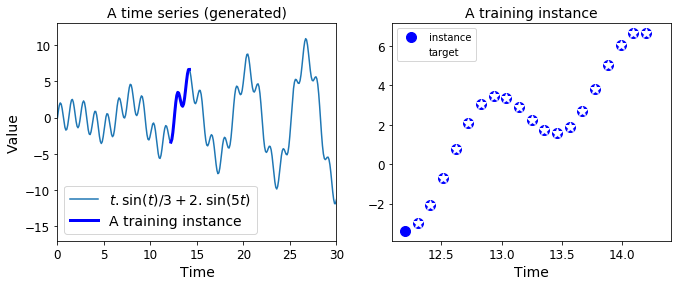

In [36]:
t = np.linspace(t_min, t_max, int((t_max - t_min) / resolution))

n_steps = 20
t_instance = np.linspace(12.2, 12.2 + resolution * (n_steps + 1), n_steps + 1)

plt.figure(figsize=(11,4))
plt.subplot(121)
plt.title("A time series (generated)", fontsize=14)
plt.plot(t, time_series(t), label=r"$t . \sin(t) / 3 + 2 . \sin(5t)$")
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "b-", linewidth=3, label="A training instance")
plt.legend(loc="lower left", fontsize=14)
plt.axis([0, 30, -17, 13])
plt.xlabel("Time")
plt.ylabel("Value")

plt.subplot(122)
plt.title("A training instance", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "w*", markersize=10, label="target")
plt.legend(loc="upper left")
plt.xlabel("Time")


plt.show()

In [38]:
reset_graph()

n_steps = 20
n_inputs = 1
n_neurons = 100
n_outputs = 1

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

cell = tf.contrib.rnn.OutputProjectionWrapper(
    tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu),
    output_size=n_outputs)

outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

learning_rate = 0.001

loss = tf.reduce_mean(tf.square(outputs - y)) # MSE
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [39]:
n_iterations = 1500
batch_size = 50

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        X_batch, y_batch = next_batch(batch_size, n_steps)
        sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if iteration % 100 == 0:
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\tMSE:", mse)
    
    saver.save(sess, "./my_time_series_model") # not shown in the book

0 	MSE: 13.6543
100 	MSE: 0.538476
200 	MSE: 0.168532
300 	MSE: 0.0879579
400 	MSE: 0.0633425
500 	MSE: 0.061859
600 	MSE: 0.0558801
700 	MSE: 0.0498718
800 	MSE: 0.0518417
900 	MSE: 0.0482838
1000 	MSE: 0.0483549
1100 	MSE: 0.0503321
1200 	MSE: 0.0412116
1300 	MSE: 0.0488435
1400 	MSE: 0.0426057


In [40]:
# Prediction

with tf.Session() as sess:                          # not shown in the book
    saver.restore(sess, "./my_time_series_model")   # not shown

    X_new = time_series(np.array(t_instance[:-1].reshape(-1, n_steps, n_inputs)))
    y_pred = sess.run(outputs, feed_dict={X: X_new})

y_pred

INFO:tensorflow:Restoring parameters from ./my_time_series_model


array([[[-3.42596436],
        [-2.48950148],
        [-1.1358937 ],
        [ 0.75142008],
        [ 2.19939661],
        [ 3.14104176],
        [ 3.54801917],
        [ 3.34113908],
        [ 2.82566142],
        [ 2.17759967],
        [ 1.65191436],
        [ 1.55619645],
        [ 1.94783175],
        [ 2.74632907],
        [ 3.89091802],
        [ 5.11678171],
        [ 6.13101864],
        [ 6.67043686],
        [ 6.62354612],
        [ 6.05428839]]], dtype=float32)

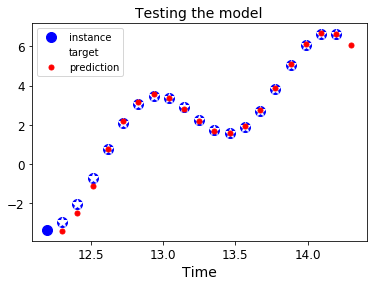

In [42]:
plt.title("Testing the model", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "w*", markersize=10, label="target")
plt.plot(t_instance[1:], y_pred[0,:,0], "r.", markersize=10, label="prediction")
plt.legend(loc="upper left")
plt.xlabel("Time")
plt.show()

In [45]:
with tf.Session() as sess:                        # not shown in the book
    saver.restore(sess, "./my_time_series_model") # not shown

    sequence = [0.] * n_steps   # Feeding zeros to use only recursive connections
    for iteration in range(300):
        X_batch = np.array(sequence[-n_steps:]).reshape(1, n_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        sequence.append(y_pred[0, -1, 0])

INFO:tensorflow:Restoring parameters from ./my_time_series_model


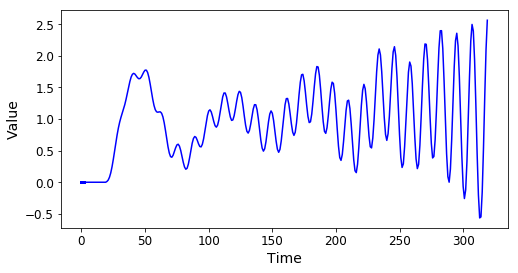

In [46]:
plt.figure(figsize=(8,4))
plt.plot(np.arange(len(sequence)), sequence, "b-")
plt.plot(t[:n_steps], sequence[:n_steps], "b-", linewidth=3)
plt.xlabel("Time")
plt.ylabel("Value")
plt.show()

# Long-Short Term Memory (LSTM)

![](http://webpages.uncc.edu/mlee173/teach/itcs6156/images/class/RNN_LSTM.png)


In [47]:
reset_graph()

lstm_cell = tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons)

n_steps = 28
n_inputs = 28
n_neurons = 150
n_outputs = 10
n_layers = 3

learning_rate = 0.001

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.int32, [None])

lstm_cells = [tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons)
              for layer in range(n_layers)]
multi_cell = tf.contrib.rnn.MultiRNNCell(lstm_cells)
outputs, states = tf.nn.dynamic_rnn(multi_cell, X, dtype=tf.float32)
top_layer_h_state = states[-1][1]
logits = tf.layers.dense(top_layer_h_state, n_outputs, name="softmax")
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy, name="loss")
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.global_variables_initializer()

In [48]:
n_epochs = 10
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            X_batch = X_batch.reshape((batch_size, n_steps, n_inputs))
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print("Epoch", epoch, "Train accuracy =", acc_train, "Test accuracy =", acc_test)

Epoch 0 Train accuracy = 0.946667 Test accuracy = 0.9462
Epoch 1 Train accuracy = 0.973333 Test accuracy = 0.9705
Epoch 2 Train accuracy = 0.973333 Test accuracy = 0.9729
Epoch 3 Train accuracy = 0.986667 Test accuracy = 0.9809
Epoch 4 Train accuracy = 0.993333 Test accuracy = 0.9851
Epoch 5 Train accuracy = 0.993333 Test accuracy = 0.9852
Epoch 6 Train accuracy = 0.986667 Test accuracy = 0.9864
Epoch 7 Train accuracy = 1.0 Test accuracy = 0.9868
Epoch 8 Train accuracy = 0.993333 Test accuracy = 0.9871
Epoch 9 Train accuracy = 1.0 Test accuracy = 0.9868


# Gated Recurrent Unit (GRU)

![](http://webpages.uncc.edu/mlee173/teach/itcs6156/images/class/RNN_GRU.png)


In [53]:
reset_graph()

n_steps = 28
n_inputs = 28
n_neurons = 150
n_outputs = 10
n_layers = 3

learning_rate = 0.001

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.int32, [None])

gru_cells = [tf.contrib.rnn.GRUCell(num_units=n_neurons)
              for layer in range(n_layers)]
multi_cell = tf.contrib.rnn.MultiRNNCell(gru_cells)
outputs, states = tf.nn.dynamic_rnn(multi_cell, X, dtype=tf.float32)
top_layer_h_state = states[-1]
logits = tf.layers.dense(top_layer_h_state, n_outputs, name="softmax")
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy, name="loss")
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.global_variables_initializer()

In [54]:
states

(<tf.Tensor 'rnn/while/Exit_2:0' shape=(?, 150) dtype=float32>,
 <tf.Tensor 'rnn/while/Exit_3:0' shape=(?, 150) dtype=float32>,
 <tf.Tensor 'rnn/while/Exit_4:0' shape=(?, 150) dtype=float32>)

In [ ]:
n_epochs = 10
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            X_batch = X_batch.reshape((batch_size, n_steps, n_inputs))
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print("Epoch", epoch, "Train accuracy =", acc_train, "Test accuracy =", acc_test)

Epoch 0 Train accuracy = 0.98 Test accuracy = 0.9676
Epoch 1 Train accuracy = 0.993333 Test accuracy = 0.9791
Epoch 2 Train accuracy = 0.993333 Test accuracy = 0.9782
Epoch 3 Train accuracy = 0.993333 Test accuracy = 0.9839
Epoch 4 Train accuracy = 0.98 Test accuracy = 0.9865


# Natural Language Processing

![](http://webpages.uncc.edu/mlee173/teach/itcs6156/images/class/RNN_machine_translation.png)


# Brain Computer Interfaces 


<table>
<tr>
<td>
<img src="http://www.cs.colostate.edu/~anderson/wp/wp-content/uploads/2017/08/bciuser.jpg" width=400/>
</td>
<td>
<img src="https://cdn.technologyreview.com/i/legacy/eeg_x220.jpg?sw=280" />
</td>
</tr>
</table>

[Forney, et al.](http://www.elliottforney.com/wp-content/uploads/forney2015echo.pdf) suggested a interesting way to generate EEG signal with RNN. Although it is fake signal, it models the noisy EEG signals for different tasks successfully. 
